# Initialize Model

In [1]:
from package import embedding, llm, agent_llm, url, model
from package.utils import format_docs, prompt_2_str

# Import Lib

In [2]:
import json

In [3]:
from operator import itemgetter

In [4]:
from langchain.agents import load_tools, initialize_agent
from langchain.tools import BaseTool
import yfinance as yahoo_finance
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

In [5]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from typing import List, Optional

In [6]:
from langchain_core.tools import tool

In [7]:
import yfinance as yahoo_finance

# LangGraph: DAG Agentic Workflow  

In this notebook, we will use LangGraph to control the simple concept workflow.  
We will have a router agent who can route our user_input request into the proper function to execute.  
Then we will return the result at the end.  

The reason we don't use simple LangChain Agent becuase it is incompatible with all LLM models.  
Hence, LangGraph is more suitable and seems to be the argnostic framework which can be plug and play on the model part.  
This ability surely saves our developer's day a lot.

## Initialize all agents and their dependenceis

In [8]:
class RouterExtractor(BaseModel):
    """Elements of a message."""
    intention:Optional[str] = Field(default=None, description="The intention of the message")
    action:Optional[str] = Field(default=None, description="The action of the message")
    summary:Optional[str] = Field(default=None, description="The summary of the message")
    message:Optional[str] = Field(default=None, description="The input message")

parser = PydanticOutputParser(pydantic_object=RouterExtractor)

In [9]:
prompt_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an excellent agent who is always helpful in every situation.
Your job is to answer the user_input by using the excution_result.
Remember make the answer useful, concise and easy to understand.

Here is a user_input: \n\n{user_input}\n\n
Here is a execution_result: \n\n{execution_result}<|eot_id|>

<|start_header_id|>excellent agent<|end_header_id|>
"""
prompt = PromptTemplate.from_template(prompt_template)

generate_chain = prompt | llm

In [10]:
prompt_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a stock investor who knows inside out of all trade markets.
Your job is to extract the ticker based on the user_input.
Do not add premable or explanation. Return only the ticker name in string format

Here is a user_input: \n\n{user_input}<|eot_id|>

<|start_header_id|>stock investor<|end_header_id|>
"""
prompt = PromptTemplate.from_template(prompt_template)

ticker_chain = prompt | llm

@tool
def stock_query(user_input:str) -> str:
    """get the current stock's price"""
    ticker = ticker_chain.invoke({"user_input": user_input})
    ticker = yahoo_finance.Ticker(ticker)
    return ticker.info.get("currentPrice")

In [11]:
@tool
def add():
    """add numbers"""
    return "add"
@tool
def minus():
    """minus numbers"""
    return "minus"

## Gathering the tools and thier variance

In [12]:
# Just simple tools
tools = [add, minus, stock_query]

# This one is gonna be in the prompt for router_llm
tool_name_n_desc = {tool.name:tool.description for tool in tools}

# for the lazy guys like me, I don't wanna write a lot of agents
# so I put all tools in one place and let the router agent to decide
# which tool to be used
tool_dict = {tool.name: tool for tool in tools}

In [13]:
tool_name_n_desc

{'add': 'add numbers',
 'minus': 'minus numbers',
 'stock_query': "get the current stock's price"}

In [14]:
prompt_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an excellent agent who always know which tool is best to accommplish the task.
Your job is to use the user_input and decide which tool to use based on the tool's description in the tools.
Remember do not add preamble or explanation.
If you cannot find the match, use not_found.
Here is a tool: \n\n{tools}\n\n
Provide the answer in JSON format in which key is equal to function_name.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
Here is a user_input: \n\n{user_input}\n\n <|eot_id|>

<|start_header_id|>agent<|end_header_id|>
"""
prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["user_input"],
    partial_variables={"tools": tool_name_n_desc},
)
router_llm = (
    prompt
    | prompt_2_str
    | llm
    | JsonOutputParser()
)

## Small test for router_llm

In [15]:
%%time
user_input = "1+1 is equal to?"
router_llm.invoke({"user_input": user_input})

CPU times: total: 0 ns
Wall time: 2.83 s


{'function_name': 'add'}

In [16]:
%%time
user_input = "1-1 is equal to?"
router_llm.invoke({"user_input": user_input})

CPU times: total: 0 ns
Wall time: 2.83 s


{'function_name': 'minus'}

In [17]:
%%time
user_input = "What is apple stock's price now?"
router_llm.invoke({"user_input": user_input})

CPU times: total: 0 ns
Wall time: 2.89 s


{'function_name': 'stock_query'}

In [18]:
%%time
user_input = "What is Microsoft stock's price now?"
router_llm.invoke({"user_input": user_input})

CPU times: total: 15.6 ms
Wall time: 2.91 s


{'function_name': 'stock_query'}

In [19]:
%%time
user_input = "Banana is yummy, haha"
router_llm.invoke({"user_input": user_input})

CPU times: total: 0 ns
Wall time: 2.91 s


{'function_name': 'not_found'}

# Construct LangGraph DAG

In [20]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.documents import Document

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        user_input: the user's input
        generation: LLM generation
        function_name: the name of functions for the next execution
        execution_result: the execution's result
    """

    user_input: str
    generation: str
    function_name: str
    execution_result: str

def agent_router(state):
    """
    Route the user to match the right agent.
    Args:
        state (dict) : The current graph state
    Returns:
        state (dict) : The user's intent and function_name
    """
    print("----ROUTE----")
    user_input = state['user_input']
    response = router_llm.invoke({"user_input": user_input})
    function_name = response["function_name"]
    return {"function_name": function_name}

def execute_tool(state):
    """
    Execute the tool based on function_name
    Args:
        state (dict) : The current graph state
    Returns:
        state (dict) : The execution's result
    """
    print(f"----EXECUTE----")
    function_name = state["function_name"]
    print(f"----START: {function_name}----")
    func = tool_dict[function_name]
    user_input = state["user_input"]
    response = func.run({"user_input":user_input})
    print(f"----END: {function_name}----")
    return {"execution_result": str(response)}

def return_result(state):
    """
    Return all
    Args:
        state (dict) : The current graph state
    Returns:
        state (dict) : The current graph state
    """
    print(f"----RETURN RESULT----")
    user_input = state["user_input"]
    execution_result = state["execution_result"]
    query = {"user_input": user_input, "execution_result": execution_result}
    response = generate_chain.invoke(query)
    return {"generation": response}

In [21]:
from langgraph.graph import END, StateGraph

# I choose this for loop method because I don't wanna repeat myself over and over.
nodes = [agent_router, execute_tool, return_result]

workflow = StateGraph(GraphState)
for node in nodes:
    workflow.add_node(node.__name__, node)

In [22]:
# The edge part couldn't loop for now, but I find the way in the future
workflow.set_entry_point(agent_router.__name__)
workflow.add_edge(agent_router.__name__, execute_tool.__name__)
workflow.add_edge(execute_tool.__name__, return_result.__name__)
workflow.add_edge(return_result.__name__, END)

In [23]:
app = workflow.compile()

## See the workflow

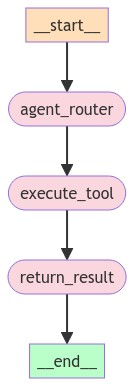

In [30]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# Time for the test!!

In [24]:
%%time
user_input = "What is apple stock's price now?"
query = {"user_input": user_input}
response = app.invoke(query)
print(response["generation"])

----ROUTE----
----EXECUTE----
----START: stock_query----
----END: stock_query----
----RETURN RESULT----
I'd be happy to help!

According to my latest information, Apple's current stock price is $192.25. Please note that stock prices can fluctuate rapidly, so this figure may not reflect the current market value. If you're looking for real-time updates or want to make an informed investment decision, I recommend checking a reliable financial source or a stock trading platform for the most up-to-date information.
CPU times: total: 0 ns
Wall time: 13.1 s


In [25]:
%%time
user_input = "What is Microsoft stock's price now?"
query = {"user_input": user_input}
response = app.invoke(query)
print(response["generation"])

----ROUTE----
----EXECUTE----
----START: stock_query----
----END: stock_query----
----RETURN RESULT----
I'd be happy to help you with that!

According to my latest information, the current price of Microsoft (MSFT) stock is $415.13. Please note that stock prices can fluctuate rapidly and may change by the time you read this. If you're considering making a purchase or sale decision, I recommend checking the most up-to-date pricing information before doing so.
CPU times: total: 0 ns
Wall time: 12.2 s


# Play Ground

In [27]:
while True:
    user_input = input()
    if user_input in ["exit"]:
        break
    query = {"user_input": user_input}
    response = app.invoke(query)
    print(response["generation"])

 exit
